In [121]:
import pandas as pd
import nltk
import numpy as np
from scipy.sparse import linalg

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn import svm
from sklearn.linear_model import RidgeClassifier
from sklearn import decomposition
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn import exceptions

import warnings
warnings.simplefilter(action = "ignore", category = exceptions.UndefinedMetricWarning)

In [2]:
df = pd.read_csv('../article_contents.csv')

In [3]:
len(df)

291

In [4]:
df.head(1)

,country,url,tag,title,meta_description,content
0,Afghanistan,http://www.independent.co.uk/news/world/asia/1...,Disasters,160 killed and hundreds left stranded by flood...,Flash flooding across Afghanistan and Pakistan...,Flash flooding across Afghanistan and Pakistan...


In [5]:
def prepare_data(df):
    df['meta_description'].fillna('', inplace=True)
    df['content'].fillna('', inplace=True)
    df['title'].fillna('', inplace=True)
    df['all_text'] = df['title'] + ' ' + df['meta_description'] + ' ' + df['content']
    
    tokenizer = nltk.tokenize.WordPunctTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    all_text = df['all_text'].apply(lambda x: tokenizer.tokenize(x))
    all_text = all_text.apply(lambda x: [lemmatizer.lemmatize(t) for t in x])
    all_text = all_text.apply(lambda x: ' '.join([t for t in x if not any(d.isdigit() for d in t)]))
    
    
    titles = df['title'].apply(lambda x: tokenizer.tokenize(x))
    titles = titles.apply(lambda x: [lemmatizer.lemmatize(t) for t in x])
    titles = titles.apply(lambda x: ' '.join([t for t in x if not any(d.isdigit() for d in t)]))
    
    labels = df['tag'].map({'Conflict and violence': 1, 'Disasters': 0})
    
    return all_text, titles, labels

In [ ]:
def lsi_model(tfidf_text=None, svd_text=None, k=50, seed=42):
    tfidf = TfidfVectorizer(ngram_range=(1,4), stop_words='english')
    tfidf_model = tfidf.fit(tfidf)

In [10]:
train_text, train_titles, train_labels = prepare_data(df)

In [11]:
news = nltk.corpus.reuters
reuters_docs = [news.raw(n) for n in news.fileids()]

In [12]:
def remove_newline(text):
    ''' Removes new line and &nbsp characters.
    '''
    text = text.replace('\n', ' ')
    text = text.replace('\xa0', ' ')
    text = text.replace('\\', '')
    return text

for i, _ in enumerate(reuters_docs):
    reuters_docs[i] = remove_newline(reuters_docs[i])

In [13]:
for text in train_text:
    reuters_docs.append(text)

In [160]:
tfidf = TfidfVectorizer(ngram_range=(1,4), stop_words='english')
tfidf_reuters = tfidf.fit(reuters_docs)
#tfidf_train = tfidf.fit(train_text)

In [161]:
del(train_text_tfidf)

In [162]:
#train_text_tfidf = tfidf.transform(train_text)
train_titles_tfidf = tfidf.transform(train_titles)

In [163]:
reuters_tfids = tfidf.transform(train_titles)

In [100]:
train_titles_tfidf

<291x1990846 sparse matrix of type '<class 'numpy.float64'>'
	with 5255 stored elements in Compressed Sparse Row format>

In [173]:
svd = decomposition.TruncatedSVD(n_components=25)
#svd.fit(train_text_tfidf)
#svd.fit(train_titles_tfidf)
svd.fit(train_titles_tfidf)

TruncatedSVD(algorithm='randomized', n_components=25, n_iter=5,
       random_state=None, tol=0.0)

In [174]:
#train_text_svd = svd.transform(train_text_tfidf)
train_titles_svd = svd.transform(train_titles_tfidf)

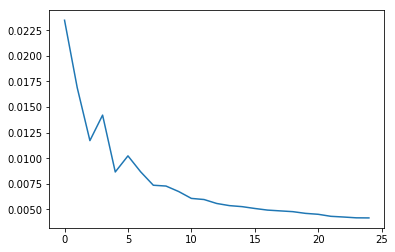

In [175]:
plt.plot(svd.explained_variance_)

In [124]:
param_grid = [{'kernel': ['linear'], 
              'gamma': [.01, .03, 0.1, 0.3, 1.0, 3.0],
              'class_weight':[{0:1,1:1}, {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5}],
              'C': [1/x for x in [.003 , .01, .03, 0.1, 0.3, 1.0, 3.0, 10.0]]}]

scores = ['precision', 'recall']

svc = svm.SVC()
clf = model_selection.GridSearchCV(svc, param_grid=param_grid, cv=5, scoring='f1')

In [194]:
clf.fit(train_titles_svd, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0], 'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}], 'C': [333.3333333333333, 100.0, 33.333333333333336, 10.0, 3.3333333333333335, 1.0, 0.3333333333333333, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [195]:
clf.best_score_

0.52310042000763657

In [196]:
clf.best_params_

{'C': 333.3333333333333,
 'class_weight': {0: 1, 1: 5},
 'gamma': 0.01,
 'kernel': 'linear'}

In [197]:
best_clf = clf.best_estimator_

In [200]:
best_predictions = clf.predict(train_titles_svd)

In [201]:
target_names = ['Disasters', 'Conflict and violence']
print(classification_report(train_labels, best_predictions, target_names=target_names))

                       precision    recall  f1-score   support

            Disasters       0.99      0.94      0.96       260
Conflict and violence       0.65      0.90      0.76        31

          avg / total       0.95      0.94      0.94       291



# Learning Curves

In [202]:
train_sizes, train_scores, valid_scores = learning_curve(
    best_clf, train_text_svd, train_labels, train_sizes=[50, 60, 100, 150, 200, 231], cv=5)

In [203]:
train_scores = [np.mean(x) for x in train_scores]
valid_scores = [np.mean(x) for x in valid_scores]

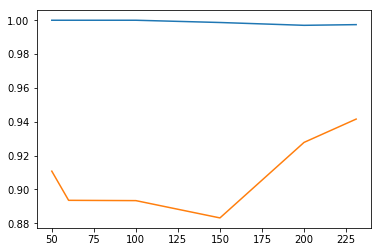

In [204]:
plt.plot(train_sizes, train_scores)
plt.plot(train_sizes, valid_scores)

# Testing

In [185]:
df_test = pd.read_csv('../article_contents2.csv')

In [186]:
df_test.head(1)

,Unnamed: 0,title,meta_description,content,url,tag
0,0,Islamist violence strains a poor nation's warm...,"DIFFA, Niger (Reuters) - Unlike many victims o...","DIFFA, Niger (Reuters) - Unlike many victims o...",http://www.thefiscaltimes.com/latestnews/2016/...,Conflict and violence


In [ ]:
drop 19, 20

In [187]:
df_test.drop('Unnamed: 0', axis=1, inplace=True)

In [188]:
df_test.drop(19, inplace=True)
df_test.drop(20, inplace=True)

In [157]:
df_test.drop(20, inplace=True)

In [189]:
df_test.iloc[20]

title               UN to Place This Nation Under Scrutiny for Gha...
meta_description    Sudan's president, Omar al-Bashir, is the worl...
content             The Sudanese Church of Christ, Bahri, North Kh...
url                 http://www.charismanews.com/world/56936-un-to-...
tag                                             Conflict and violence
Name: 22, dtype: object

In [190]:
test_text, test_titles, test_labels = prepare_data(df_test)
test_labels.fillna(0, inplace=True)

In [191]:
test_text_tfidf = tfidf.transform(test_text)
test_text_svd = svd.transform(test_text_tfidf)

In [192]:
test_titles_tfidf = tfidf.transform(test_titles)
test_titles_svd = svd.transform(test_titles_tfidf)

In [205]:
predictions = best_clf.predict(test_titles_svd)

In [206]:
predictions

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0])

In [207]:
sum(predictions == test_labels)/len(test_labels)

0.60273972602739723

In [143]:
target_names = ['Disasters', 'Conflict and violence']
print(classification_report(test_labels, predictions, target_names=target_names))

                       precision    recall  f1-score   support

            Disasters       0.76      0.88      0.81        42
Conflict and violence       0.81      0.64      0.71        33

          avg / total       0.78      0.77      0.77        75



# Appendix 1 - Approaches

## Approach 1

0.59

1. Fit TfIdf on training data
2. Fit SVD on training data (k=200)
3. Transform training data with SVD
4. Optimise SVM classifier

```
precision    recall  f1-score   support

            Disasters       1.00      0.99      1.00       260
Conflict and violence       0.94      1.00      0.97        31

          avg / total       0.99      0.99      0.99       291
```          
5. Best classifier on test data

```
precision    recall  f1-score   support

            Disasters       0.58      1.00      0.74        42
Conflict and violence       1.00      0.09      0.17        33

          avg / total       0.77      0.60      0.49        75
```

## Approach 2

0.72

1. Fit TfIdf on Reuters corpus
2. Fit SVD on training data (k=100)
3. Transform training data with SVD
4. Optimise SVM classifier

```
                       precision    recall  f1-score   support

            Disasters       1.00      0.98      0.99       260
Conflict and violence       0.84      1.00      0.91        31

          avg / total       0.98      0.98      0.98       291
```          
5. Best classifier on test data

```
                       precision    recall  f1-score   support

            Disasters       0.67      0.98      0.80        42
Conflict and violence       0.93      0.39      0.55        33

          avg / total       0.78      0.72      0.69        75
```

## Approach 3

0.57

1. Fit TfIdf on Reuters corpus
2. Fit SVD on training data (k=50)
3. Transform training data with SVD
4. Optimise SVM classifier

```
                       precision    recall  f1-score   support

            Disasters       1.00      0.98      0.99       260
Conflict and violence       0.84      1.00      0.91        31

          avg / total       0.98      0.98      0.98       291
```          
5. Best classifier on test data

```
                       precision    recall  f1-score   support

            Disasters       0.67      0.98      0.80        42
Conflict and violence       0.93      0.39      0.55        33

          avg / total       0.78      0.72      0.69        75
```

## Approach 4

0.77

1. Fit TfIdf on Reuters corpus
2. Fit SVD on training titles (k=50)
3. Transform training data with SVD
4. Optimise SVM classifier

```
                       precision    recall  f1-score   support

            Disasters       1.00      0.98      0.99       260
Conflict and violence       0.88      0.97      0.92        31

          avg / total       0.98      0.98      0.98       291
```

5. Best classifier on test data

```
                       precision    recall  f1-score   support

            Disasters       0.57      0.93      0.71        42
Conflict and violence       0.57      0.12      0.20        33

          avg / total       0.57      0.57      0.49        75
```

